### In this notebook I use dask

This is demonstrating how to use dask for our data processing. 

### Load the data

In [1]:
from data_processing import load_data, get_files, parse_filename, drop_nd_rows
from feature_extraction import extract_fft_features, extract_time_domain_features
from transformations import interpolate_zeros, replace_outliers_with_zeros, replace_outliers
import pandas as pd
import dask
from dask import do
from os.path import split
from dask import delayed, compute
import numpy as np

from os import listdir
import pandas as pd
from os.path import join, split
from data_processing import *
%matplotlib inline

from scipy.stats import shapiro
from scipy.stats.mstats import normaltest
from scipy.stats import iqr
%load_ext autoreload

In [2]:
files =get_files()[:2]

```python

def parse_filename(filename, split_file=False):
    """Parses m filename to get the pertinent information"""
    if split_file:
        filename = split(filename)[1]

    # strip out the .mat
    filename = filename.replace('.mat', '')

    # parse the remaing part
    return [int(part) for part in filename.split('_')]

def map_functions(data, functions):
    """maps a list of functions to data and returns as a list of results
    Parameters: 
        data: data to be computed on
        functions(list): a list of functions
    Returns: 
        results(list): a list of the results
    """
    return [fun(data) for fun in functions]


def process_data(file_name, functions=None):
    """Processes one file at a time for extracting features
    Parameters: 
        file_name(str): the file name
        functions(list): a list of functions for extracting features
    Returns: 
        res(pd.DataFrame): a one row data frame with the features in the columns    
    """
    
    if functions is None: 
        functions = [extract_time_domain_features,extract_fft_features]
    
    # get the time series and parse the filename for the info
    time_series = load_data(file_name,True)[0]
    patient,number,condition = parse_filename(file_name, True)
    
    # create an index and prefix df
    index = pd.MultiIndex.from_tuples([(patient, number, condition)], 
                                      names=['Patient', 'TraceNumber', 'Condition'])

    prefix_df = pd.DataFrame({'Patient':patient,
                              'TraceNumber':number,
                              'Condition':condition},
                             index = [0]
                              )
    
    # create a list two hold the data frames, call the functions and then concatenate the resulting dataframes
    res = [prefix_df]
    res.extend(map_functions(time_series,functions))
    res = pd.concat(res, axis =1)
    res.index = index
    return res
    
def process_multiple_data(files):
    """uses dask to process many files in parallel"""
    # set up the compute graph
    graph = delayed([delayed(process_data)(file_) for file_ in files])
    # compute the graph
    results = compute(graph)
    
    return pd.concat([results[0][i] for i in range(len(files))]) ```

features = process_multiple_data(files)

In [3]:
def map_functions(data, functions):
    """maps a list of functions to data (slowly)"""
    return [fun(data) for fun in functions]

import numpy as np
functions = [np.sin, np.cos]
map_functions(1,functions)

### Try the new code


In [4]:
processor = Processor()

In [5]:
test_path = ['/Users/crivera5/Desktop/test']
processor = Processor()
#res= processor.process_data(test_path)
#res

### Compute the training sets

In [6]:
paths =['/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG/train_1',
       '/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG/train_2',
       '/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG/train_3']

```python 

processor = Processor()
res = processor.process_data(paths)  ```

In [7]:
files = get_data_files(paths)
#%timeit processor.process_file(files[0])

In [8]:
%timeit load_data(files[0])
df = load_data(files[0], False)[0]

1 loop, best of 3: 1.27 s per loop


I ran this code on the old version of processor. 
```python 

%time processor.pre_process(df)
df = processor.pre_process(df)

```
CPU times: user 1min 52s, sys: 39.5 s, total: 2min 32s
Wall time: 2min 32s

In [9]:
%timeit drop_nd_rows(df)
df = drop_nd_rows(df)

10 loops, best of 3: 33 ms per loop


In [10]:
%timeit interpolate_zeros(df)
df = interpolate_zeros(df)

10 loops, best of 3: 50.1 ms per loop


In [11]:
df = load_data(files[0], False)[0]
df = drop_nd_rows(df)

In [12]:
%timeit interpolate_zeros(df)
%timeit df.replace(to_replace = 0.0, value = np.nan).interpolate(method = 'linear')
df2 = df.replace(to_replace = 0.0, value = np.nan).interpolate(method = 'linear')

10 loops, best of 3: 49.7 ms per loop
10 loops, best of 3: 50.1 ms per loop


In [13]:
s = df.iloc[:,0]

In [14]:
%timeit replace_outliers(s)

100 loops, best of 3: 4.15 ms per loop


In [15]:
%timeit df.apply(replace_outliers)

10 loops, best of 3: 75.6 ms per loop


In [16]:
df= df.apply(replace_outliers)

def replace_outliers(s, factor=2.0, replacement=0.0):
    """ convert outliers to zero
    Parameters:
        s(pd.Series): the input series
        factor(float): the factor to multiply the interquartile range
    Returns:
        replacement(float): the value for which to replace
    """
    s = s.copy()
    iqr_ = iqr(s)
    outliers = s.between(-factor*iqr_, factor*iqr_)==False
    s.loc[outliers] =replacement
    return outliers

In [28]:
%autoreload

In [18]:
outliers =replace_outliers(s)

In [19]:
df = load_data(files[0], False)[0]
df2= processor.pre_process(df)

In [20]:
%timeit processor.pre_process(df)

10 loops, best of 3: 190 ms per loop


In [21]:
%timeit processor.process_file(files[0])

1 loop, best of 3: 7.13 s per loop


(-150, 150)

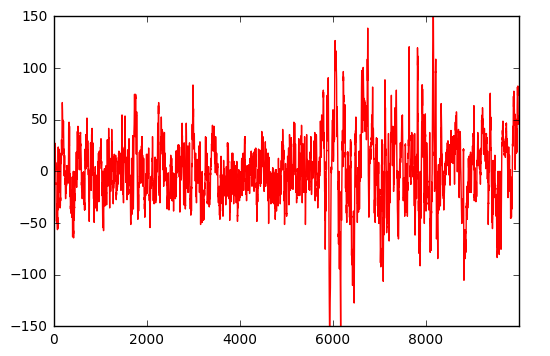

In [23]:
ax = df[1].iloc[:10000].plot( color = 'red')
ax.set_ylim(-150,150)

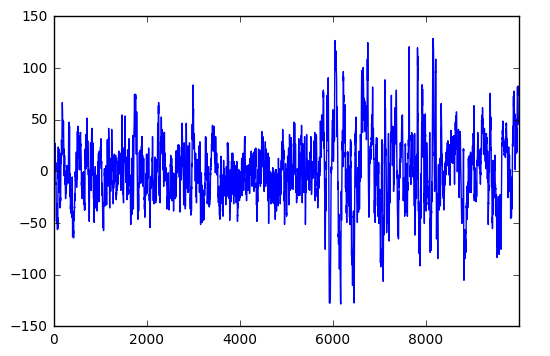

In [22]:
ax =df2[1].iloc[:10000].plot()


In [24]:
f =join('/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG/train_1','1_45_1.mat')

In [31]:
processor = Processor()
processor.process_file(f)

In [33]:
path = '/Users/crivera5/Desktop/test'
f = join(path, '1_45_1.mat')
processor.process_file(f)

In [41]:
%timeit processor.process_data([path])

1 loop, best of 3: 32 s per loop


In [36]:
res= processor.process_data([path])

In [37]:
res

,Variance 1,Variance 2,Variance 3,Variance 4,Variance 5,Variance 6,Variance 7,Variance 8,Variance 9,Variance 10,...,SpectralEntropy 10,SpectralEntropy 11,SpectralEntropy 12,SpectralEntropy 13,SpectralEntropy 14,SpectralEntropy 15,SpectralEntropy 16,patient,dataset_id,pre_ictal
0,1073.931885,1161.097290,1470.846680,2951.005371,1198.252319,960.193604,2339.797607,963.822815,1267.933838,2953.739990,...,-1.399412,-1.350736,-1.282937,-1.436835,-1.549374,-1.348690,-1.272833,1,1,0
0,1481.801514,1013.530823,1022.900879,1863.541504,1018.228577,727.197632,1694.157837,814.355286,1420.159180,1783.165527,...,-1.327658,-1.257569,-1.129733,-1.265166,-1.354834,-1.274629,-1.185108,1,1,1
0,1068.162354,1182.911377,1284.068970,2728.372314,1170.491699,912.205078,1822.436157,905.655396,1176.623291,2790.583984,...,-1.406088,-1.366321,-1.261190,-1.431227,-1.555662,-1.319113,-1.268535,1,3,0


In [40]:
len(listdir(path))-1

12